In [5]:
# Cell to hide - just an option and import other functions

import pandas as pd
pd.set_option('display.max_columns', 27)

%run 1-functions.ipynb

Your customer would like to have a model that can predict the mean speed of a vessel based on its type and size. As we will see together, this task is not the easiest with the dataset we have, as it contains a lot of different ships with different goals at sea.

In [6]:
import pandas as pd

static_data = pd.read_csv('./static_data.csv')

## Prediction using the whole dataset

We will start by predicting simply the ``MeanSOG`` using the ``VesselType``, ``Length``, ``Width`` and ``Draft``. Let's add the attribute names into the variables ``x`` and ``y``.

In [7]:
x = ['VesselType', 'Length', 'Width', 'Draft']
y = ['MeanSOG']

Now we can use the function ``knn_regression()`` to make predictions.

In [8]:
from sklearn.metrics import mean_absolute_error

predictions, y_test = knn_regression(static_data, x, y)
print('MAE: ' + str(mean_absolute_error(predictions, y_test)))

MAE: 1.2733923934326852


To better undestand if the MAE is good, we need to know the distribution, the max and min values of the attribute we are trying to predict:

In [9]:
static_data['MeanSOG'].describe()

count    1520.000000
mean        1.034825
std         2.936439
min        -0.100000
25%         0.000000
50%         0.012633
75%         0.072000
max        20.360811
Name: MeanSOG, dtype: float64

The mean value of ``MeanSOG`` is ``1.03`` knots, so we can imagine that our MAE of ``1.27`` is not a very good performance. To try to understand why we get this performance, let's visually analyze the distribution of the attribute and the predictions made by the model.

In [10]:
static_data['MeanSOG'].plot.hist()

First, we see that the dataset contains a lot of low values for the attribute ``MeanSOG``. Let's look at the predictions made:

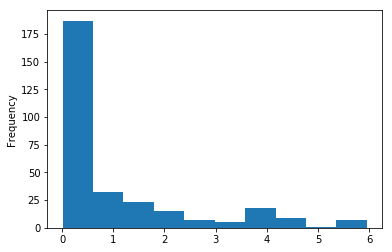

In [11]:
# We need to rearrange the list predictions to be able to use the function hist()
pred = []
for element in predictions:
    pred.append(element[0])
    
pd.Series(pred).plot.hist()

Let's compare this histogram with the one of the real values:

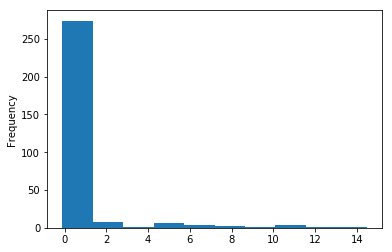

In [12]:
pd.Series(y_test['MeanSOG']).plot.hist()

We see that the model gives much more predictions of low value, but there is still a big difference between predictions and true labels.

How could we try to build a model that gives good predictions for the mean speed of ships with such an unbalanced dataset?

One solution could be to split the dataset between low speed ships and "normal" speed ships. When the customer wants to make a prediction, they should be able to tell if the ship they want to predict the speed is mobile or not, and then be able to select the right model: for mobile or immobile ships. Let's have a look at this idea.

## Split the dataset

According to the distribution of the data we saw before, we can tell that most low values are under 1. So, let's split the dataset into mobile and immobile ships, taking the value 1 of mean speed for the threshold. For the selection of the data, we use the function [loc()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html).

We will do the analysis on the mobile ships only, as it doesn't seem interesting to predict the mean speed of an immobile ship.

In [13]:
mobile = static_data.loc[static_data['MeanSOG'] >= 1]

Now let's try to make predictions for the new dataset and analyze the performance.

In [14]:
# Prediction for mobile ships

predictions2, y_test2 = knn_regression(mobile, x, y)
print('MAE: ' + str(mean_absolute_error(predictions2, y_test2)))

MAE: 2.8503720152323386


In [15]:
mobile['MeanSOG'].mean()

7.006852415734686

Without looking at the histograms, we can already get an idea of the performance of the model.

## Compare the results

The model for mobile ships seems to be giving better results compared to the mean value of the dataset. Of course, the MAE in general is much higher than the one of the model with the whole dataset, but we saw that the model seemed to be only good for predicting the low values of MeanSOG.
Let's check this out.

In [16]:
pred = []
for element in predictions:
    pred.append(element[0])

# Create two lists to collect true labels with MeanSOG >= 1 and the corresponding predictions
pred_sup1 = []
y_test_sup1 = []

i = 0
for value in y_test['MeanSOG']:
    if value >= 1:
        y_test_sup1.append(value)
        pred_sup1.append(pred[i])
    i = i + 1
    
print(mean_absolute_error(pred_sup1, y_test_sup1))

3.950739471015331


The mean absolute error on the mobile ships with the first model (the one using the whole dataset) is higher than the one we got with the new model when splitting the data. This is a good sign that splitting the data helped to create a better model for the moving ships.

To go further, we can have a look at the boxplots of the predictions of both models. This is another type of visualization of the data which can instantly inform us on the state of the prediction and the possible need to build several models for several cases.

{'whiskers': [<matplotlib.lines.Line2D at 0x1fd51e0a320>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd51e0a9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd51dfdef0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd51e0add8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd51e133c8>],
 'means': []}

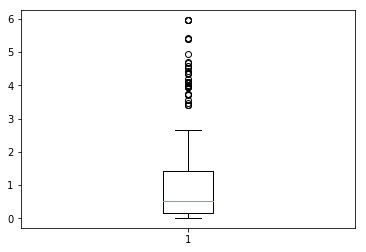

In [18]:
import matplotlib.pyplot as plt

# Boxplot of the predictions with the first model
plt.boxplot(predictions)

We can see with this boxplot that most predicted values are low, and the highest values are considered as outliers. Let's compare it with the boxplot of the predictions made by the second model.

{'whiskers': [<matplotlib.lines.Line2D at 0x1fd51e54e48>,
 'caps': [<matplotlib.lines.Line2D at 0x1fd51e667f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fd51e54cf8>],
 'medians': [<matplotlib.lines.Line2D at 0x1fd51e66e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd51e66f60>],
 'means': []}

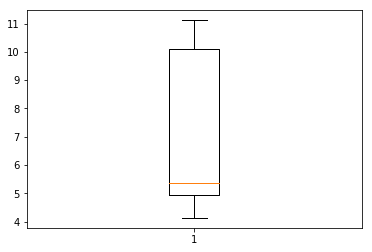

In [19]:
# Boxplot of the predictions with the second model
plt.boxplot(predictions2)

Here, the predictions are much more homogeneous. This seems more acceptable for a predictive model, as we want a model that can generalize on new data.

## Generalization

What this experiment taught us is that sometimes, the data used to build a model are too heterogeneous and should be splitted, if they could. In our case, it makes sense to split the data between mobile and immobile ships, as it is an easy feature to verify before using a model to predict the speed. Also, predicting the speed of a ship that is actually moving seems much more interesting than predicting the speed of a ship that doesn't move.

In general, it is important to check that the data used for training a model are a good representation of the environment in which the model will be in use later.

## Quiz

__TODO: make quiz__